# Customer Segmentation Exploratory Analysis

## Initial Data Exploration

In [101]:
import pandas as pd

# Load the dataset
df = pd.read_csv('../data/raw_data/customer_data.csv')

# Show the first few rows of the data
df.head()


,CustomerID,Age,Income,SpendingScore
0,1,51,57003,33
1,2,41,63273,53
2,3,62,57522,71
3,4,52,57981,96
4,5,32,34912,89


Here we can see the first few rows of the dataset, which includes features such as Age, Income, and Spending Score. We will look at some summary statistics next

In [102]:
# Summary statistics
df.describe()

,CustomerID,Age,Income,SpendingScore
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,40.774000,58123.500000,50.471000
std,288.819436,13.322929,22899.366364,29.124103
min,1.000000,18.000000,20378.000000,1.000000
25%,250.750000,29.750000,38018.000000,25.000000
50%,500.500000,41.000000,57966.500000,50.000000
75%,750.250000,52.000000,77503.250000,77.000000
max,1000.000000,64.000000,99991.000000,99.000000


## 

## Feature Selection Rationale

We are considering the following features for our clustering model:

- Age: Could indicate different purchasing behaviors at different life stages.
- Income: Higher income could mean more spending or different types of spending.
- Spending Score: A measure of the customer's spending behavior.

In [103]:
from sklearn.decomposition import PCA
from scipy.stats import zscore

# Load the original data
df = pd.read_csv('../data/processed_data/segmented_customers.csv')

# Remove outliers using Z-score
z_scores = np.abs(zscore(df))
df = df[(z_scores < 3).all(axis=1)]

# Dimensionality Reduction: PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)

## Trial Runs of Different Clustering Methods

In [104]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt

# Select features for clustering
X = df[['Age', 'Income', 'SpendingScore']]

# KMeans
kmeans = KMeans(n_clusters=5)
kmeans_labels = kmeans.fit_predict(X)

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=5)
agg_labels = agg_clustering.fit_predict(X)


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Tuning Hyperparameters

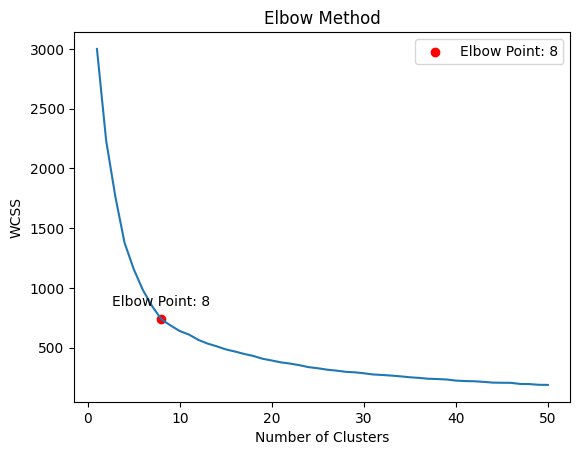

         CustomerID       Age    Income  SpendingScore
Cluster                                               
0             782.5  0.104442 -0.006169      -0.015790
1             512.5  0.081670  0.115491       0.011566
2             373.5 -0.012458 -0.084295       0.038367
3             135.5 -0.023080 -0.044887      -0.017707
4             935.5 -0.122823  0.125011      -0.010367
5             240.0 -0.095988 -0.040621      -0.056596
6             636.0  0.012479 -0.008897      -0.025576
7              45.5  0.009462 -0.086545       0.091841


In [105]:
def find_elbow_point(wcss):
    n = len(wcss)
    x1, y1 = 1, wcss[0]
    xN, yN = n, wcss[-1]

    max_distance = 0
    elbow_point = 1

    for i in range(1, len(wcss)):
        x0, y0 = i + 1, wcss[i]
        numerator = abs((yN - y1) * x0 - (xN - x1) * y0 + xN * y1 - yN * x1)
        denominator = ((yN - y1)**2 + (xN - x1)**2)**0.5
        distance = numerator / denominator

        if distance > max_distance:
            max_distance = distance
            elbow_point = i + 1
            
    return elbow_point

# Using Elbow Method to find an initial guess for the number of cluseters
wcss = []
for i in range(1, 51):  # 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Find elbow point
elbow_point = find_elbow_point(wcss)
optimal_clusters = elbow_point

plt.plot(range(1, 51), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

# Marking the elbow point
plt.scatter(elbow_point, wcss[elbow_point-1], color='red', label=f'Elbow Point: {elbow_point}')
plt.annotate(f'Elbow Point: {elbow_point}', (elbow_point, wcss[elbow_point-1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.legend()

# Then run your AgglomerativeClustering
from sklearn.cluster import AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=optimal_clusters)
agg_clustering.fit(df)


plt.show()

df['Cluster'] = agg_clustering.labels_

# Summary statistics for each cluster
print(df.groupby('Cluster').mean())

                CustomerID           Age        Income  SpendingScore  Cluster
Cluster_DBSCAN                                                                
-1                   500.5 -6.594725e-17  1.443290e-18   1.176836e-16    3.143


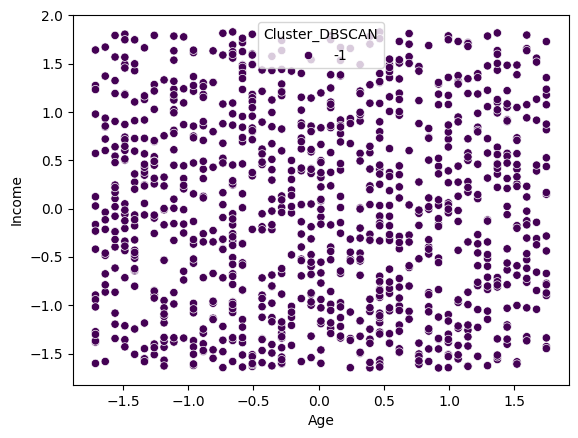

In [106]:
# DBSCAN
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df)
df['Cluster_DBSCAN'] = dbscan_labels

# Summary statistics for each cluster
print(df.groupby('Cluster_DBSCAN').mean())

sns.scatterplot(x='Age', y='Income', hue='Cluster_DBSCAN', data=df, palette='viridis')

# Filtering noise points
noise_points = df[df['Cluster_DBSCAN'] == -1]

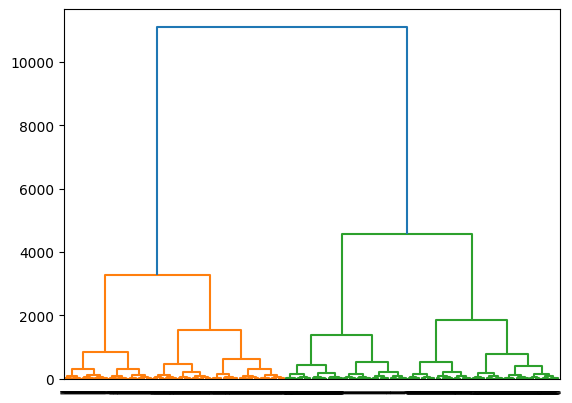

In [107]:
from scipy.cluster.hierarchy import dendrogram, linkage
linked = linkage(df, 'ward')
dendrogram(linked, labels=agg_clustering.labels_)
plt.show()


In [109]:
# Using the Silhouette Score method for futher validation
from sklearn.metrics import silhouette_score

silhouette_scores = []
for n_clusters in range(2, 21):  
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10)
    preds = clusterer.fit_predict(X)
    centers = clusterer.cluster_centers_
    score = silhouette_score(X, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.24921137010506436)
For n_clusters = 3, silhouette score is 0.2501478985070752)
For n_clusters = 4, silhouette score is 0.2789113593878756)
For n_clusters = 5, silhouette score is 0.2791419652518753)
For n_clusters = 6, silhouette score is 0.29489297563109534)
For n_clusters = 7, silhouette score is 0.28855602160107263)
For n_clusters = 8, silhouette score is 0.2835188516714893)
For n_clusters = 9, silhouette score is 0.28369766981134203)
For n_clusters = 10, silhouette score is 0.2833806941887499)
For n_clusters = 11, silhouette score is 0.2873191542578116)
For n_clusters = 12, silhouette score is 0.2824598810719882)
For n_clusters = 13, silhouette score is 0.2800770683392187)
For n_clusters = 14, silhouette score is 0.27447645739589266)
For n_clusters = 15, silhouette score is 0.2683659422429704)
For n_clusters = 16, silhouette score is 0.27104835469397376)
For n_clusters = 17, silhouette score is 0.2661625692127104)
For n_clusters = 18, silho

## Explanation and Interpretation of the Clusters